### Load Data and Initial Preprocessing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the datasets generated in Phase 1
df_users = pd.read_csv('users.csv')
df_events = pd.read_csv('events.csv')

# Convert date columns to datetime objects
df_users['signup_date'] = pd.to_datetime(df_users['signup_date'])
df_events['event_timestamp'] = pd.to_datetime(df_events['event_timestamp'])

print("Data loaded. Users shape:", df_users.shape, "| Events shape:", df_events.shape)

Data loaded. Users shape: (2000, 5) | Events shape: (28540, 3)


### Assigning Cohorts

In [3]:
# Create a 'cohort_month' column based on signup_date
df_users['cohort_month'] = df_users['signup_date'].dt.to_period('M')

# Create an 'activity_month' column in events
df_events['activity_month'] = df_events['event_timestamp'].dt.to_period('M')

# Merge event data with user cohort data
df_merged = pd.merge(df_events, df_users[['user_id', 'cohort_month']], on='user_id')

df_merged.head()

,user_id,event_timestamp,event_name,activity_month,cohort_month
0,U1000,2024-03-14 06:00:00,log_meal,2024-03,2024-02
1,U1000,2024-04-09 22:00:00,log_meal,2024-04,2024-02
2,U1000,2024-03-28 07:00:00,log_meal,2024-03,2024-02
3,U1000,2024-03-05 22:00:00,log_meal,2024-03,2024-02
4,U1000,2024-04-05 20:00:00,update_profile,2024-04,2024-02


### Calculating Cohort Index

In [4]:
def calculate_cohort_index(df):
    # Calculate the difference in years and months
    year_diff = df['activity_month'].dt.year - df['cohort_month'].dt.year
    month_diff = df['activity_month'].dt.month - df['cohort_month'].dt.month
    
    # Return total months as the index
    return year_diff * 12 + month_diff

df_merged['cohort_index'] = calculate_cohort_index(df_merged)
df_merged.head(10)

,user_id,event_timestamp,event_name,activity_month,cohort_month,cohort_index
0,U1000,2024-03-14 06:00:00,log_meal,2024-03,2024-02,1
1,U1000,2024-04-09 22:00:00,log_meal,2024-04,2024-02,2
2,U1000,2024-03-28 07:00:00,log_meal,2024-03,2024-02,1
3,U1000,2024-03-05 22:00:00,log_meal,2024-03,2024-02,1
4,U1000,2024-04-05 20:00:00,update_profile,2024-04,2024-02,2
5,U1000,2024-03-08 22:00:00,log_meal,2024-03,2024-02,1
6,U1000,2024-04-07 06:00:00,log_meal,2024-04,2024-02,2
7,U1000,2024-03-05 16:00:00,log_meal,2024-03,2024-02,1
8,U1000,2024-03-01 16:00:00,log_meal,2024-03,2024-02,1
9,U1000,2024-03-30 04:00:00,session_start,2024-03,2024-02,1


### Building the Retention Matrix

In [5]:
# Group by cohort_month and cohort_index to count unique users
cohort_data = df_merged.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique().reset_index()

# Pivot the table so rows are Cohort Months and columns are Indexes
cohort_matrix = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='user_id')

# Calculate the size of each cohort (Number of users in Month 0)
cohort_sizes = cohort_matrix.iloc[:, 0]

# Divide the entire matrix by the cohort sizes to get percentages
retention_matrix = cohort_matrix.divide(cohort_sizes, axis=0)

# Round for readability
retention_matrix = retention_matrix.round(3) * 100

### Visualizing with a Heatmap

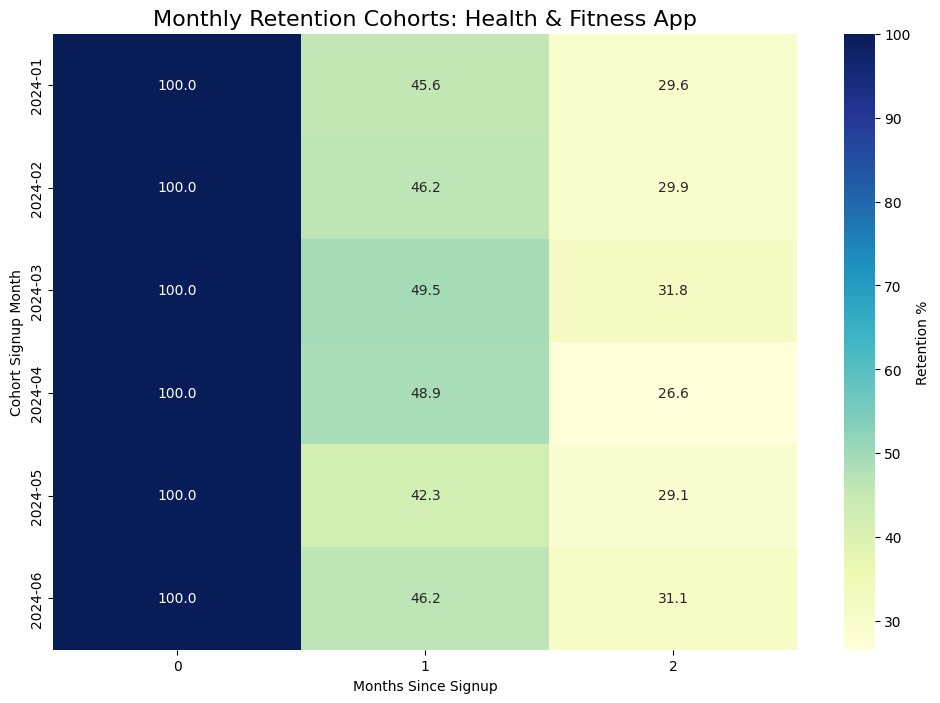

Heatmap saved as 'cohort_retention_heatmap.png'


<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(12, 8))
plt.title('Monthly Retention Cohorts: Health & Fitness App', fontsize=16)

sns.heatmap(retention_matrix, 
            annot=True, 
            fmt='.1f', 
            cmap='YlGnBu', 
            mask=retention_matrix.isnull(),
            cbar_kws={'label': 'Retention %'})

plt.ylabel('Cohort Signup Month')
plt.xlabel('Months Since Signup')
plt.show()

# Save the heatmap as PNG (high resolution, transparent background optional)
plt.savefig(
    'cohort_retention_heatmap.png',          # filename (you can change it)
    dpi=300,                                 # high resolution for portfolio / reports
    bbox_inches='tight',                     # removes extra white space around the plot
    format='png',                            # can also use 'pdf', 'jpg', etc.
    transparent=False                        # set to True if you want no background
)

print("Heatmap saved as 'cohort_retention_heatmap.png'")